# Flight Delay EDA Plots (from enriched parquet)

This notebook loads your `enriched_flights.parquet` and creates a set of quick, useful plots for delay analysis:
- Arrival delay distribution
- % flights delayed ≥ 15 min
- Top airlines by mean delay
- Weather severity vs delay
- Mean delay vs weather severity bucket
- Destinations with highest mean delay


In [1]:
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
BASE_DIR = Path.cwd()  # if you run notebook elsewhere, adjust this
PARQUET_PATH = "/home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/data_pipeline/outputs/enriched_flights.parquet"

OUT_DIR = BASE_DIR / "plots"
OUT_DIR.mkdir(exist_ok=True)

PARQUET_PATH, OUT_DIR


('/home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/data_pipeline/outputs/enriched_flights.parquet',
 PosixPath('/home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/ml-shared-notebooks/notebooks/jon/python/plots'))

In [2]:
# ------------------------------------------------------------
# LOAD DATA (only needed columns for speed)
# ------------------------------------------------------------
lf = pl.scan_parquet(PARQUET_PATH)
schema_cols = set(lf.collect_schema().names())

cols_needed = [
    "ArrDelay",
    "DepDelay",
    "ArrDelayMinutes",
    "DepDelayMinutes",
    "Reporting_Airline",
    "Origin",
    "Dest",
    "dep_weather_severity",
    "arr_weather_severity",
]
cols_present = [c for c in cols_needed if c in schema_cols]

df = lf.select(cols_present).collect(engine="streaming")
df.shape, df.columns


((222848, 9),
 ['ArrDelay',
  'DepDelay',
  'ArrDelayMinutes',
  'DepDelayMinutes',
  'Reporting_Airline',
  'Origin',
  'Dest',
  'dep_weather_severity',
  'arr_weather_severity'])

In [3]:
def savefig(name: str):
    path = OUT_DIR / f"{name}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print("Saved:", path)
    plt.show()

def to_float_np(series: pl.Series):
    return series.cast(pl.Float64, strict=False).drop_nulls().to_numpy()


## 1) Arrival Delay Distribution (minutes)

Saved: /home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/ml-shared-notebooks/notebooks/jon/python/plots/arrival_delay_distribution.png


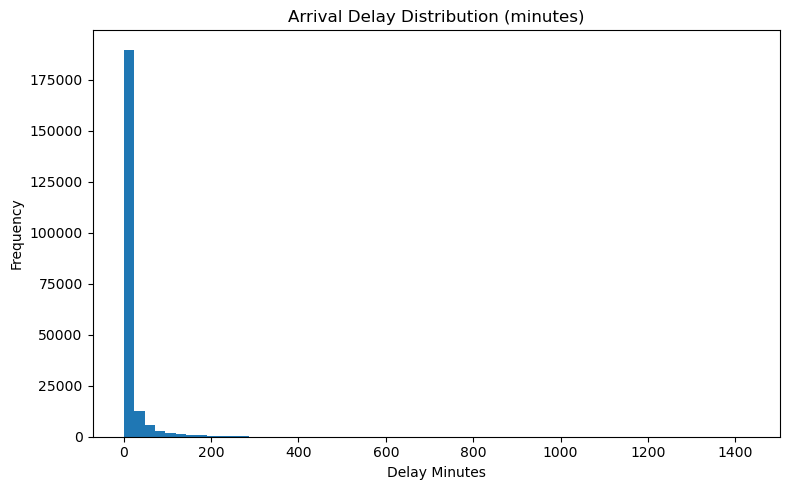

In [4]:
if "ArrDelayMinutes" in df.columns:
    arr = to_float_np(df["ArrDelayMinutes"])
    plt.figure(figsize=(8,5))
    plt.hist(arr, bins=60)
    plt.title("Arrival Delay Distribution (minutes)")
    plt.xlabel("Delay Minutes")
    plt.ylabel("Frequency")
    savefig("arrival_delay_distribution")
else:
    print("ArrDelayMinutes not found")


## 2) Delay Classification View (≥ 15 minutes)

Saved: /home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/ml-shared-notebooks/notebooks/jon/python/plots/delay_classification.png


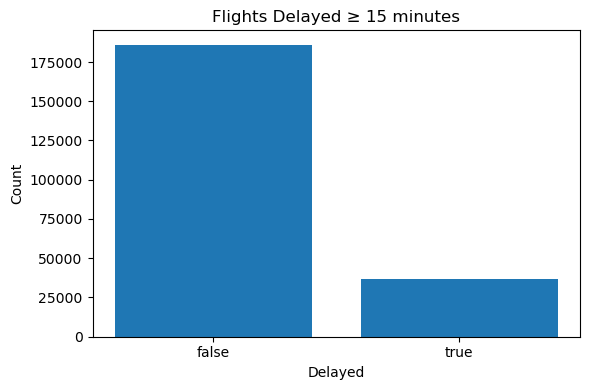

In [5]:
if "ArrDelayMinutes" in df.columns:
    delayed = (
        df.select(
            (pl.col("ArrDelayMinutes").cast(pl.Float64, strict=False).fill_null(0) >= 15)
            .alias("Delayed15")
        )
        .group_by("Delayed15")
        .agg(pl.len().alias("count"))
        .sort("Delayed15")
    )

    plt.figure(figsize=(6,4))
    plt.bar(delayed["Delayed15"].cast(pl.Utf8).to_list(), delayed["count"].to_list())
    plt.title("Flights Delayed ≥ 15 minutes")
    plt.xlabel("Delayed")
    plt.ylabel("Count")
    savefig("delay_classification")
else:
    print("ArrDelayMinutes not found")


## 3) Top Airlines by Mean Arrival Delay

Saved: /home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/ml-shared-notebooks/notebooks/jon/python/plots/carrier_mean_delay.png


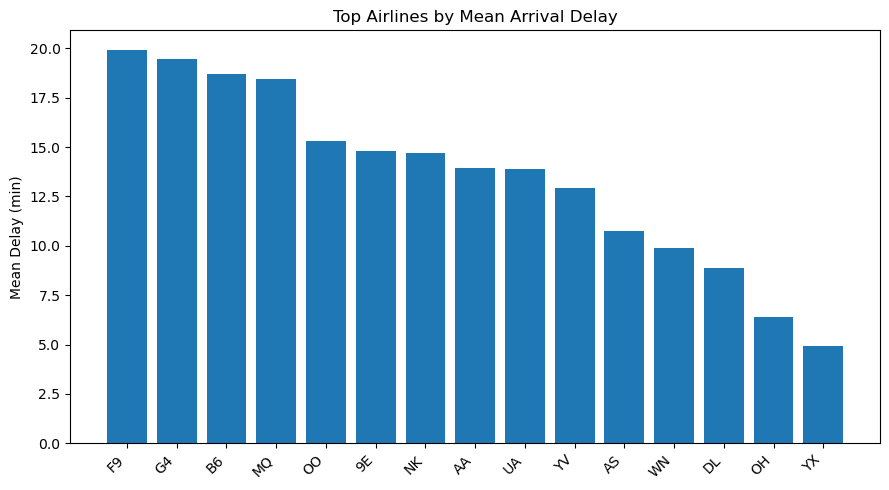

In [6]:
if {"Reporting_Airline", "ArrDelayMinutes"}.issubset(set(df.columns)):
    airline_stats = (
        df.lazy()
        .group_by("Reporting_Airline")
        .agg(pl.col("ArrDelayMinutes").cast(pl.Float64, strict=False).mean().alias("mean_delay"))
        .sort("mean_delay", descending=True)
        .limit(15)
        .collect()
    )

    plt.figure(figsize=(9,5))
    plt.bar(airline_stats["Reporting_Airline"].to_list(), airline_stats["mean_delay"].to_list())
    plt.xticks(rotation=45, ha="right")
    plt.title("Top Airlines by Mean Arrival Delay")
    plt.ylabel("Mean Delay (min)")
    savefig("carrier_mean_delay")
else:
    print("Reporting_Airline or ArrDelayMinutes not found")


## 4) Departure Weather Severity vs Arrival Delay

Saved: /home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/ml-shared-notebooks/notebooks/jon/python/plots/weather_vs_delay.png


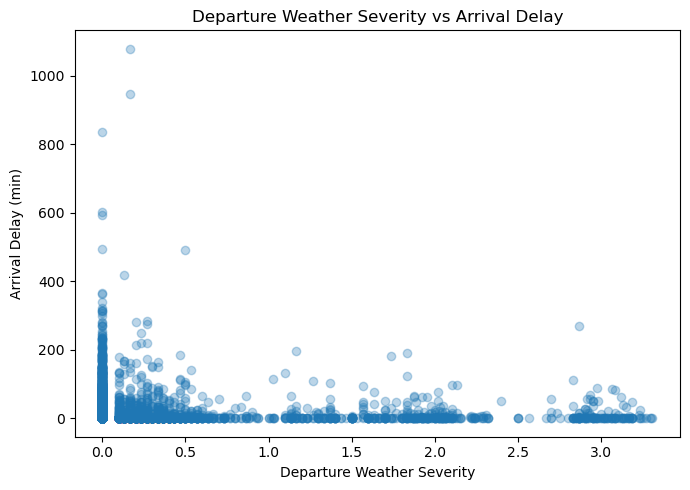

In [7]:
if {"dep_weather_severity", "ArrDelayMinutes"}.issubset(set(df.columns)):
    sample = (
        df.select([
            pl.col("dep_weather_severity").cast(pl.Float64, strict=False),
            pl.col("ArrDelayMinutes").cast(pl.Float64, strict=False),
        ])
        .drop_nulls()
        .sample(min(10_000, df.height), seed=0)
    )

    plt.figure(figsize=(7,5))
    plt.scatter(sample["dep_weather_severity"].to_list(), sample["ArrDelayMinutes"].to_list(), alpha=0.3)
    plt.title("Departure Weather Severity vs Arrival Delay")
    plt.xlabel("Departure Weather Severity")
    plt.ylabel("Arrival Delay (min)")
    savefig("weather_vs_delay")
else:
    print("dep_weather_severity or ArrDelayMinutes not found")


## 5) Mean Arrival Delay vs Weather Severity Bucket

Saved: /home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/ml-shared-notebooks/notebooks/jon/python/plots/delay_vs_weather_bucket.png


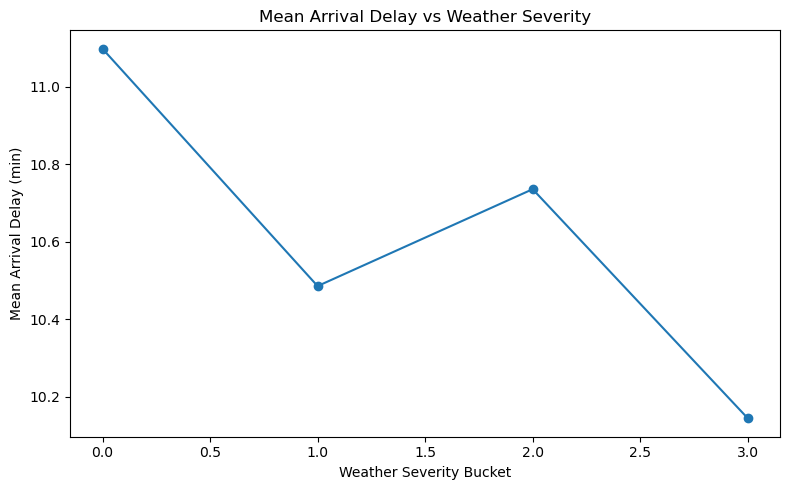

In [9]:
if {"dep_weather_severity", "ArrDelayMinutes"}.issubset(set(df.columns)):
    bucketed = (
        df.lazy()
        .with_columns(pl.col("dep_weather_severity").cast(pl.Float64, strict=False).floor().alias("wx_bucket"))
        .group_by("wx_bucket")
        .agg(pl.col("ArrDelayMinutes").cast(pl.Float64, strict=False).mean().alias("mean_delay"))
        .sort("wx_bucket")
        .collect()
    )

    plt.figure(figsize=(8,5))
    plt.plot(bucketed["wx_bucket"].to_list(), bucketed["mean_delay"].to_list(), marker="o")
    plt.title("Mean Arrival Delay vs Weather Severity")
    plt.xlabel("Weather Severity Bucket")
    plt.ylabel("Mean Arrival Delay (min)")
    savefig("delay_vs_weather_bucket")
else:
    print("dep_weather_severity or ArrDelayMinutes not found")


## 6) Destinations with Highest Mean Arrival Delay

Saved: /home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/ml-shared-notebooks/notebooks/jon/python/plots/destinations_delay.png


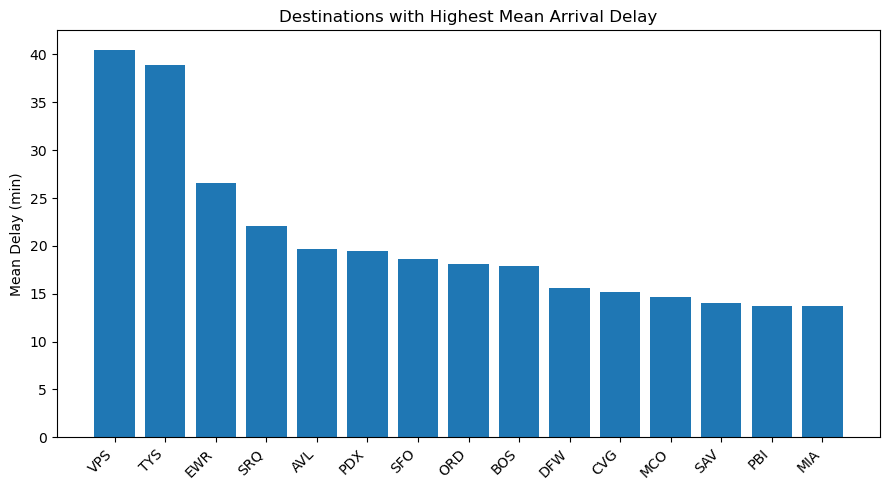

In [10]:
if {"Dest", "ArrDelayMinutes"}.issubset(set(df.columns)):
    top_dest = (
        df.lazy()
        .group_by("Dest")
        .agg(pl.col("ArrDelayMinutes").cast(pl.Float64, strict=False).mean().alias("mean_delay"))
        .sort("mean_delay", descending=True)
        .limit(15)
        .collect()
    )

    plt.figure(figsize=(9,5))
    plt.bar(top_dest["Dest"].to_list(), top_dest["mean_delay"].to_list())
    plt.xticks(rotation=45, ha="right")
    plt.title("Destinations with Highest Mean Arrival Delay")
    plt.ylabel("Mean Delay (min)")
    savefig("destinations_delay")
else:
    print("Dest or ArrDelayMinutes not found")


## Done
Plots are saved to the `plots/` directory as PNG files.